In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#Ondalık sayıların virgülden sonra 2 basamağını göstermesi için ayar 
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("Kütüphaneler başarıyla yüklendi")

Kütüphaneler başarıyla yüklendi


In [3]:
# Veri setinin bulunduğu URL (Online Retail Veri Seti)
url = "https://raw.githubusercontent.com/guipsamora/pandas_exercises/master/07_Visualization/Online_Retail/Online_Retail.csv"

# Veriyi okuyoruz (Bazı özel karakterler içerdiği için 'latin1' kodlaması kullanıyoruz)
df = pd.read_csv(url, encoding='latin1')

#Veri setinin doğru gelip gelmediğini kontrol etmek için ilk 5 satıra bakalım

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.00,United Kingdom


In [4]:
#1. Hangi sütunda kaç tane eksik(boş) veri var?
print("-------EKSİK DEĞER SAYILARI-------")
print(df.isnull().sum())
print("\n" + "#"*30 + "\n")

#2. sayısal verilerin özetine bakalım (Min/ Max değerleri önemli)
print("---İSTATİSTİKSEL ÖZET---")
print(df.describe().T)

-------EKSİK DEĞER SAYILARI-------
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

##############################

---İSTATİSTİKSEL ÖZET---
               count     mean     std       min      25%      50%      75%  \
Quantity   541909.00     9.55  218.08 -80995.00     1.00     3.00    10.00   
UnitPrice  541909.00     4.61   96.76 -11062.06     1.25     2.08     4.13   
CustomerID 406829.00 15287.69 1713.60  12346.00 13953.00 15152.00 16791.00   

                max  
Quantity   80995.00  
UnitPrice  38970.00  
CustomerID 18287.00  


In [7]:
#1. Eksik CustomerID'leri siliyoruz (Kime satıldığı belli değilse işimize yaramaz)
df.dropna(subset=['CustomerID'], inplace=True)

#2.İadeleri(Negatif Miktar) ve Hatalı Fiyatları(Negatif/Sıfır Fiyat) eliyoru<
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] >0)]

#3. Analiz için yeni bir sütun ekleyelim: Toplam Kazanç (Total Price)
# Ciro = Adet * Birim Fiyat
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# ÖNEMLİ: Tarih sütununu datetime formatına çevirmeliyiz (Yoksa matematik yapamayız)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
print("Uyarılar giderildi ve tarih formatı düzeltildi.")
df.info() # InvoiceDate'in 'datetime' olduğunu göreceksin

#Temizlik bitti, son durumu kontrol edelim
print(f"Temizlenmiş Veri Seti Boyutu: {df.shape[0]} satır")
print("\n--- TEMİZLENMİŞ İSTATİSTİKLER ---")
print(df[["Quantity", "UnitPrice", "TotalPrice"]].describe().T)

Uyarılar giderildi ve tarih formatı düzeltildi.
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB
Temizlenmiş Veri Seti Boyutu: 397884 satır

--- TEMİZLENMİŞ İSTATİSTİKLER ---
               count  mean    std  min  25%   50%   75%       max
Quantity   397884.00 12.99 179.33 1.00 2.00  6.00 12.00  80995.00
UnitP

In [8]:
# 1. Analiz Tarihini Belirleme (Verideki en son tarih + 2 gün)
today_date = df["InvoiceDate"].max() + pd.Timedelta(days=2)
print(f"Analiz Tarihimiz: {today_date}")

# 2. RFM Metriklerini Hesaplama
# Müşteri ID'sine göre gruplayıp her birinin karnesini çıkarıyoruz
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (today_date - date.max()).days, # Recency (Bugün - Son Alışveriş)
    'InvoiceNo': lambda num: num.nunique(),                     # Frequency (Eşsiz Fatura Sayısı)
    'TotalPrice': lambda price: price.sum()                     # Monetary (Toplam Harcama)
})

# Sütun isimlerini daha anlaşılır yapalım
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Monetary değeri 0 olanları (varsa) uçuralım, mantıksız olur
rfm = rfm[rfm["Monetary"] > 0]

rfm.head()

Analiz Tarihimiz: 2011-12-11 12:50:00


,Recency,Frequency,Monetary
CustomerID,,,
12346.00,327,1,77183.60
12347.00,3,7,4310.00
12348.00,76,4,1797.24
12349.00,20,1,1757.55
12350.00,311,1,334.40


In [9]:
# Recency: Düşük olan iyidir, bu yüzden puanları TERSTEN (5'ten 1'e) veriyoruz.
rfm["RecencyScore"] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# Frequency: Yüksek olan iyidir. (rank metodu, aynı sayıların çakışmasını önler)
rfm["FrequencyScore"] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

# Monetary: Yüksek olan iyidir.
rfm["MonetaryScore"] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Şimdi R ve F skorlarını yan yana getirip "RF Skorunu" oluşturuyoruz
# Örn: Recency=5, Frequency=3 ise Skor="53" olacak.
rfm["RFM_SCORE"] = (rfm['RecencyScore'].astype(str) +
                    rfm['FrequencyScore'].astype(str))

# Bakalım kime kaç puan verdik?
rfm.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
CustomerID,,,,,,,
12346.00,327,1,77183.60,1,1,5,11
12347.00,3,7,4310.00,5,5,5,55
12348.00,76,4,1797.24,2,4,4,24
12349.00,20,1,1757.55,4,1,4,41
12350.00,311,1,334.40,1,1,2,11


In [10]:
# Segment İsimlendirme Haritası (Standart RFM Map)
seg_map = {
    r'[1-2][1-2]': 'Hibernating',        # Uykudakiler (Eski ve seyrek gelenler)
    r'[1-2][3-4]': 'At_Risk',            # Riskli (Sık gelirdi ama artık gelmiyor)
    r'[1-2]5': 'Can_t_Loose',            # Kaybedemeyiz (Çok alışveriş yapmış ama terk etmiş)
    r'3[1-2]': 'About_to_Sleep',         # Uykuya dalmak üzere
    r'33': 'Need_Attention',             # Dikkat İster
    r'[3-4][4-5]': 'Loyal_Customers',    # Sadık Müşteriler
    r'41': 'Promising',                  # Umut Vaat Eden
    r'51': 'New_Customers',              # Yeni Müşteriler
    r'[4-5][2-3]': 'Potential_Loyalists',# Potansiyel Sadıklar
    r'5[4-5]': 'Champions'               # Şampiyonlar
}

# Skorları segment isimleriyle değiştiriyoruz
rfm['Segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

# Sonuçları görelim
rfm.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
CustomerID,,,,,,,,
12346.00,327,1,77183.60,1,1,5,11,Hibernating
12347.00,3,7,4310.00,5,5,5,55,Champions
12348.00,76,4,1797.24,2,4,4,24,At_Risk
12349.00,20,1,1757.55,4,1,4,41,Promising
12350.00,311,1,334.40,1,1,2,11,Hibernating


In [11]:
# Hangi segmentte kaç kişi var ve ortalama ne kadar harcamışlar?
rfm[["Segment", "Recency", "Frequency", "Monetary"]].groupby("Segment").agg(["mean", "count"])

Recency       Frequency       Monetary      
                       mean count      mean count     mean count
Segment                                                         
About_to_Sleep        54.50   351      1.16   351   461.06   351
At_Risk              156.06   580      2.86   580  1076.51   580
Can_t_Loose          133.43    63      8.38    63  2796.16    63
Champions              6.88   633     12.41   633  6857.94   633
Hibernating          218.90  1065      1.10  1065   487.71  1065
Loyal_Customers       34.47   827      6.46   827  2856.72   827
Need_Attention        54.06   186      2.33   186   889.23   186
New_Customers          7.86    42      1.00    42   388.21    42
Potential_Loyalists   18.12   492      2.01   492  1034.91   492
Promising             24.44    99      1.00    99   355.35    99

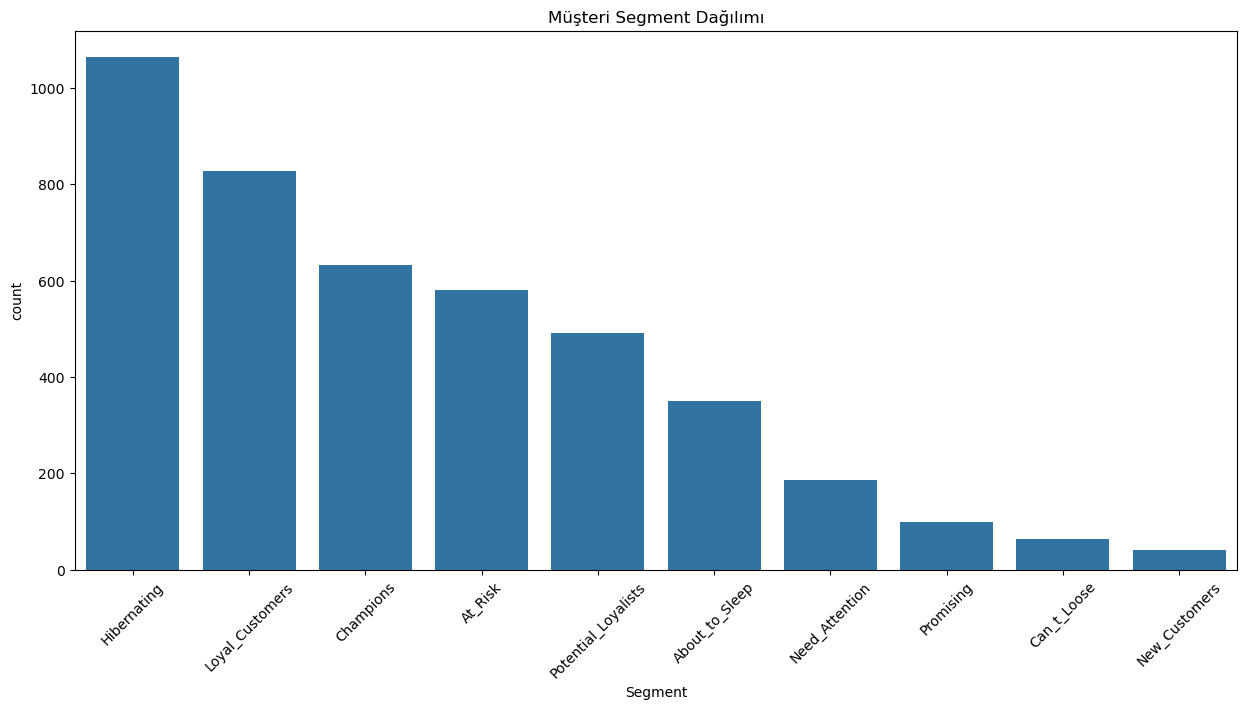

In [12]:
#Segment Dağılımını Görselleştirme
plt.figure(figsize=(15, 7))
sns.countplot(x="Segment", data=rfm, order=rfm['Segment'].value_counts().index)
plt.title("Müşteri Segment Dağılımı")
plt.xticks(rotation=45) #Yazılar sığsın diye eğiyoruz
plt.show()

In [13]:
#Biz az önce "Recency skoru 5 ise şudur" diye kuralları kendimiz koyduk. K-Means algoritması ise bize şunu diyecek: "Senin kurallarınla ilgilenmiyorum. Ben verilerin uzaydaki konumuna bakarım ve en yakın olanları bir araya toplarım."

Ancak K-Means kullanmadan önce Veri Ön İşleme (Preprocessing) yapmamız şart. Neden mi?

Çarpıklık (Skewness): Verimizde bazı müşteriler 100.000 TL harcarken bazıları 10 TL harcıyor. Bu uçurum algoritmanın kafasını karıştırır. Veriyi biraz "bastırmamız" (Log Transformation) lazım.

Ölçek Farkı (Scaling): Monetary değerleri binlerle ifade edilirken, Frequency genelde tek haneli. Algoritma büyük sayıyı "daha önemli" sanar. Hepsini aynı standarta (Örn: 0 ile 1 arasına) çekeceğiz.

In [17]:
from sklearn.preprocessing import StandardScaler
# Sadece sayısal verileri alalım
rfm_ml = rfm[['Recency', 'Frequency', 'Monetary']]

#1.Log Dönüşümü (Log Transformation)
#Pozitif çarpıklığı gidermek için logaritma alıyoruz. (+1 ekliyoruz ki log(0) hatası almayalım
rfm_log = np.log1p(rfm_ml)

#2. Standartlaştırma (Scaling)
#Veri ortalaması 0, standart sapması 1 olacak şekilde ayarlıyoruz.
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

#Verimiz makine öğrenmesine hazır!
print("Veri normalize edildi. İlk müşterinin yeni değerleri:")
print(rfm_scaled[0])

Veri normalize edildi. İlk müşterinin yeni değerleri:
[ 1.49786681 -0.95521426  3.70622476]


Makineye "Müşterileri grupla" diyeceğiz ama "Kaç gruba ayırayım?" diye soracak. 3 mü? 5 mi? 10 mu?

Bunu bulmak için Dirsek Yöntemi (Elbow Method) kullanacağız. Algoritmayı 1'den 15'e kadar farklı grup sayılarıyla çalıştırıp hatayı ölçeceğiz. Hatanın kırıldığı (dirsek yaptığı) nokta, ideal grup sayımızdı

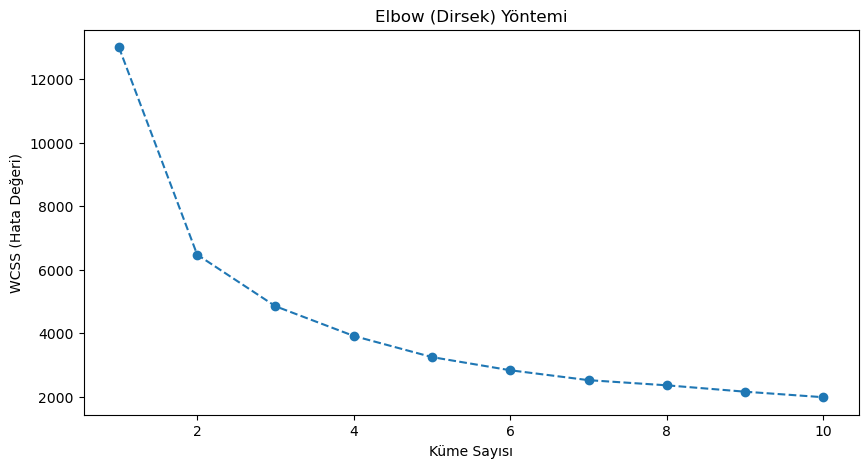

In [21]:
from sklearn.cluster import KMeans

wcss = [] #Hata kareler toplamı (Within-Cluster Sum of Square)

#1-10 a kadar küme sayılarını deniyoruz
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

#Grafiği çizelim
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow (Dirsek) Yöntemi')
plt.xlabel('Küme Sayısı')
plt.ylabel('WCSS (Hata Değeri)')
plt.show()

In [29]:
print("--- YAPAY ZEKA KÜMELERİNİN ORTALAMALARI ---")

# Düzeltme: "count" işlemini Monetary sütununun içine liste olarak ekledik.
# Böylece Monetary'nin hem ortalamasını hem de kişi sayısını verecek.
summary = rfm.groupby("K_Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": ["mean", "count"]
})

print(summary)

--- YAPAY ZEKA KÜMELERİNİN ORTALAMALARI ---
          Recency Frequency Monetary      
             mean      mean     mean count
K_Cluster                                 
0           44.38      3.29  1222.63  1705
1           18.55     13.13  7753.97   794
2          171.48      1.36   364.42  1839


X Ekseni: Harcama (Monetary)

Y Ekseni: Yenilik (Recency)

Renkler: Bizim Kümelerimiz

Grup 0: Recency çok yüksek (Eski), Monetary düşükse -> "Kaybedilenler"

Grup 1: Recency düşük (Yeni), Monetary ortaysa -> "Gelişime Açıklar"

Grup 2: Recency çok düşük (Yeni), Monetary çok yüksekse -> "VIP / Şampiy

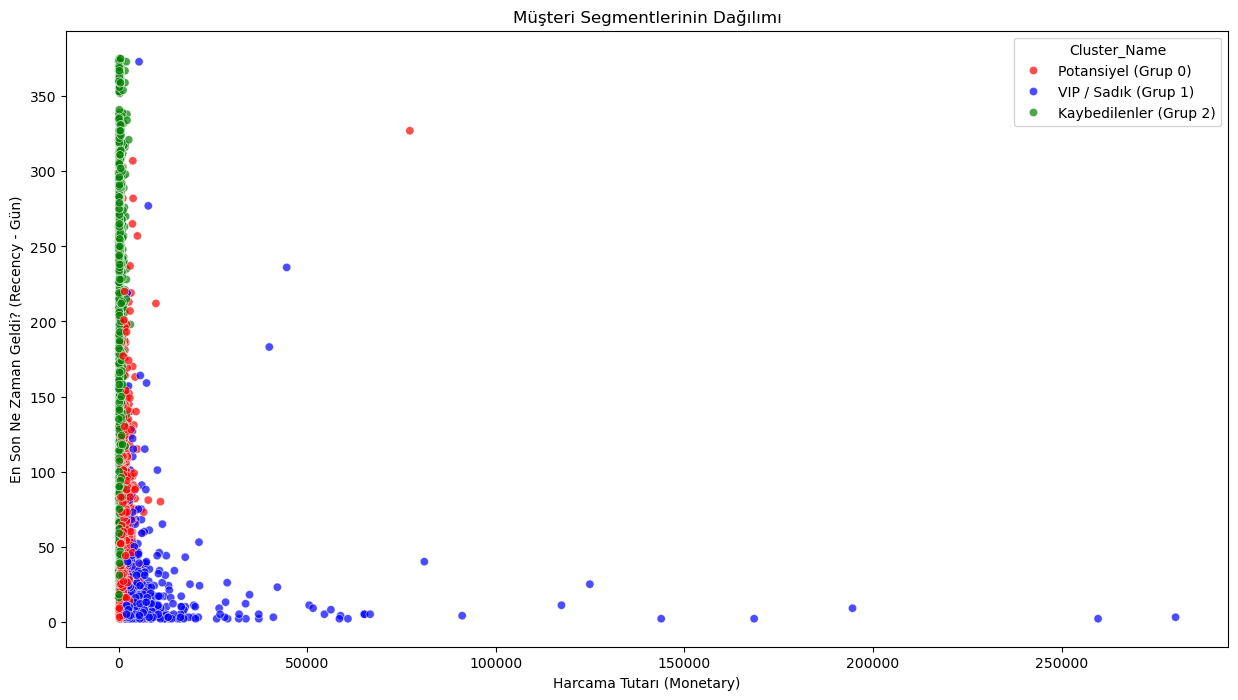

In [33]:
#Küme İsimlerini Veriye Ekleyelim (Daha anlaşılır olsun diye)
#Not: Buradaki 0,1,2 senin çıktına göre ayarlandı

df_analysis = rfm.copy()
df_analysis["Cluster_Name"] = df_analysis["K_Cluster"].map({
    1: "VIP / Sadık (Grup 1)",
    0: "Potansiyel (Grup 0)",
    2: "Kaybedilenler (Grup 2)"
})

#Grafiği Çizelim

plt.figure(figsize=(15, 8))
sns.scatterplot(
    x="Monetary",
    y="Recency",
    hue="Cluster_Name",
    palette=["red", "blue", "green"], #Renkleri belirledik
    data=df_analysis,
    alpha=0.7 # Saydamlık (Noktalar üst üste binerse görünsün diye)
)
plt.title("Müşteri Segmentlerinin Dağılımı")
plt.xlabel("Harcama Tutarı (Monetary)")
plt.ylabel("En Son Ne Zaman Geldi? (Recency - Gün)")
plt.show()

Mavi Noktalar (VIP / Sadık - Grup 1):

Dikkat et, grafiğin sağ altına yayılmışlar.

Anlamı: Y ekseninde (Recency) 0'a yakınlar (yani yeni gelmişler) ve X ekseninde (Monetary) sağa doğru uzanıyorlar (yani çok para harcamışlar).

Hatta en sağda 250.000 birim harcayan birkaç "Balina" (Whale) müşteri var. Bunlar şirketin en değerli varlıkları.

Yeşil Noktalar (Kaybedilenler - Grup 2):

Grafiğin sol üstünde bir duvar oluşturmuşlar.

Anlamı: Y ekseninde yukarıdalar (yani çok uzun süredir gelmiyorlar) ve X ekseninde 0'a yakınlar (para bırakmamışlar).

Makine öğrenmesi bunları "Uğraşmaya değmez" olarak işaretlemiş.

Kırmızı Noktalar (Potansiyel - Grup 0):

Grafiğin sol altına sıkışmışlar.

Anlamı: Yakın zamanda gelmişler (Recency düşük) ama henüz çok para harcamamışlar.

Strateji: Bu kitleyi "Mavi"lere dönüştürmek için "2. ürüne %50 indirim" gibi kampanyalar yapılmalı.